# Machine Learning From Scratch

## Introduction

You will implement several machine learning algorithms and evaluate their accuracy. This will be done for a downscaled version of the MNIST digit recognition dataset.

**Like in real life, some of the tasks you will be asked to do may not be possible, at least directly. In these cases, your job is to figure out why it won't work and either propose a fix (best), or provide a clear explanation why it won't work.**

For example, if the problem says to do k-nearest neighbors with a dataset of a billion points, this could require too much time to do each classification so it's infeasible to evaluate its test accuracy. In this case, you could suggest randomly downsample the data to a more manageable size, which will speed things up by may lose some accuracy. In your answer, then, you should describe the problem and how you solved it and the trade-offs.

# Data
First the code below ensures you have access to the training data (a subset of the MNIST images), consisting of 100 handwritten images of each digit.

In [ ]:
# First download the repo and change the directory to be the one where the dependencies are.
# You should only need to do this once per session. If you want to reset, do Runtime -> Disconnect and Delete Runtime
# You can always do !pwd to see the current working directory and !ls to list current files.
!git clone https://github.com/stanleybak/CS7320-AI.git
%cd CS7320-AI/ML
!ls

Cloning into 'CS7320-AI'...
remote: Enumerating objects: 2738, done.
remote: Counting objects: 100% (855/855), done.
remote: Compressing objects: 100% (372/372), done.
remote: Total 2738 (delta 522), reused 796 (delta 478), pack-reused 1883
Receiving objects: 100% (2738/2738), 285.30 MiB | 14.08 MiB/s, done.
Resolving deltas: 100% (1690/1690), done.
/content/CS7320-AI/ML
line_fitting.ipynb	ML_example.ipynb	ML_for_tictactoe_self_play.ipynb  README.md
mini-mnist-1000.pickle	ML_for_tictactoe.ipynb	MNIST.ipynb


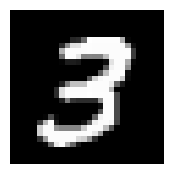

In [ ]:
import matplotlib.pyplot as plt
import pickle

# if the below fails to open, then the data file is not in the current working directory (see above code block)
with open('mini-mnist-1000.pickle', 'rb') as f:
  data = pickle.load(f)

im3 = data['images'][300] # 100 images of each digit
plt.figure(figsize=(2, 2))  # Adjust size as needed
plt.imshow(im3, cmap='gray')
plt.axis('off')
plt.show()

# Downscaling Images

MNIST images are originally 28x28. We will train our models not just on the original images, but also on downscaled images with the following sizes: 14x14, 7x7, 4x4, 2x2. The next code block shows one way to do downscaling. As you can tell from the output, we cannot expect our model's accuracy will be too high on lower resolution versions, although it's unclear how much better you can do than random chance, which should have a 10% accuracy.

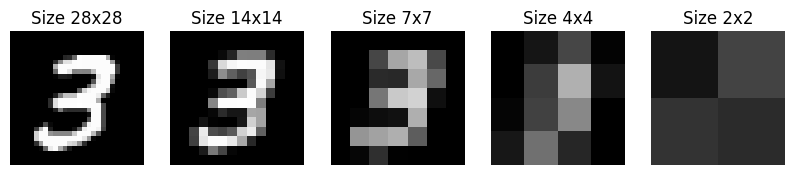

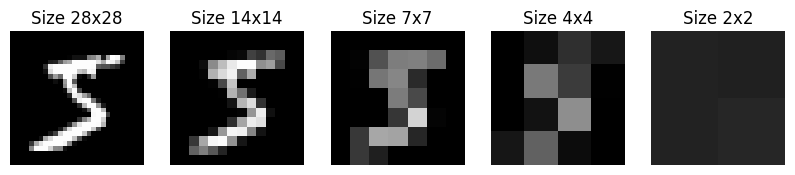

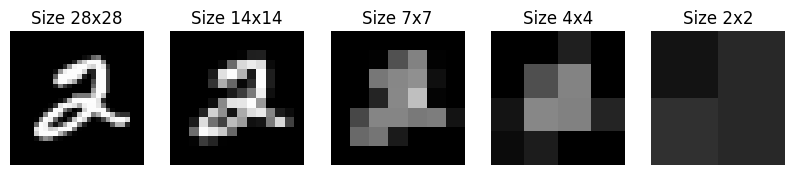

In [ ]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

# Function to downscale an image to different sizes
def downscale_image(image, downscaled_size):
    block_size = 28 // downscaled_size
    downscaled = np.zeros((downscaled_size, downscaled_size))
    for i in range(downscaled_size):
        for j in range(downscaled_size):
            # Calculate the average for each block
            block = image[i*block_size:(i+1)*block_size, j*block_size:(j+1)*block_size]
            downscaled[i, j] = np.mean(block)
    return downscaled

# Load the dataset (assuming this file is in your working directory)
with open('mini-mnist-1000.pickle', 'rb') as f:
    data = pickle.load(f)

images = data['images']  # a list of 1000 numpy image matrices
labels = data['labels']  # a list of 1000 integer labels

# Select 3 "random" indices from the dataset
random_indices = [300, 500, 200]

# Downscale the images to multiple sizes and display them
sizes = [28, 14, 7, 4, 2]
for index in random_indices:
    fig, axs = plt.subplots(1, len(sizes), figsize=(10, 2))
    for ax, size in zip(axs, sizes):
        downscaled_image = downscale_image(images[index], size)
        ax.imshow(downscaled_image, cmap='gray', vmin=0, vmax=255)
        ax.set_title(f'Size {size}x{size}')
        ax.axis('off')
    plt.show()

---
# Tasks

Your data contains 100 images in each class. When training models, use 80% of training, 10% for validation and 10% for testing. Make sure the data is balanced in each class when splitting.

---
## Task 1: Linear Classifier [20 points]

First, implement a linear classifier. The simplest way to do this is to adapt linear regression approaches that we learned about in class, where the output is a real number. For classification, we can let one category be an output of 1.0 and the other -1.0. Then, after the classifier is trained we can use the sign of the output to determine the predicted class.

However, since in MNIST there are multiple classes (10 digits, not just 2), we need to adapt the approach further. We will try both of the following two popular strategies: One-vs-Rest (OvR) and One-vs-One (OvO).

**One-vs-Rest (OvR)** is a strategy for using binary classification algorithms for multiclass problems. In this approach, a separate binary classifier is trained for each class, which predicts whether an instance belongs to that class or not, making it the 'one' against all other classes (the 'rest'). For a new input instance, compute the output of all classifiers. The predicted class is the one whose corresponding classifier gives the highest output value.

**One-vs-One (OvO)** is another strategy where a binary classifier is trained for every pair of classes. If there are N classes, you will train N(N−1)/2 classifiers. For a new input, evaluate it using all N(N−1)/2​ classifiers. Count the number of times each class is predicted over all binary classifications. The class with the highest count is selected as the final prediction.

### Report Results
Report the test accuracy for OvR and OvO, for each of the input image sizes, 28x28, 14x14, 7x7, 4x4, 2x2. A table may be helpful. Also report any interesting observations.

In [ ]:
class LinearClassifier:

  def train_ovr(self, matrix, labels):
    """Trains the linear classifier on a data matrix and corresponding labels using One-vs-Rest (OvR)"""

    # add a column of ones to the data matrix
    matrix = np.hstack((np.ones((matrix.shape[0], 1)), matrix))

    # initialize list of weights
    self.weights_ovr = []

    # for every digit (positive class)
    for positive in range(10):

      # assign 1 or -1 to labels depending on if it is in the positive class
      assigned_labels = np.vectorize(lambda x: 1 if x == positive else -1)(labels)

      # calculate weights using analytical solution to linear regression
      weights = np.linalg.pinv(matrix.T @ matrix) @ matrix.T @ assigned_labels

      # append weights
      self.weights_ovr.append(weights)

    # return linear classifier
    return self

  def train_ovo(self, matrix, labels):
    """Trains the linear classifier on a data matrix and corresponding labels using One-vs-One (OvO)"""

    # add a column of ones to the data matrix
    matrix = np.hstack((np.ones((matrix.shape[0], 1)), matrix))

    # initialize dictionary of weights
    self.weights_ovo = {}

    # for every digit (positive class)
    for positive in range(10):

      # for every digit greater than positive (negative class)
      for negative in range(positive + 1, 10):

        # create boolean mask for positive or negative labels
        mask = np.logical_or(labels == positive, labels == negative)

        # apply the mask to data matrix and labels
        temp_matrix = matrix[mask]
        temp_labels = labels[mask]

        # assign 1 or -1 to labels depending on if it is in the positive class
        assigned_labels = np.vectorize(lambda x: 1 if x == positive else -1)(temp_labels)

        # calculate weights using analytical solution to linear regression
        weights = np.linalg.pinv(temp_matrix.T @ temp_matrix) @ temp_matrix.T @ assigned_labels

        # add weights to dictionary
        self.weights_ovo[(positive, negative)] = weights

    # return linear classifier
    return self

  def predict_ovr(self, vector):
    """Predicts a class using a feature vector using One-vs-Rest (OvR)"""

    # add a one to the feature vector
    vector = np.hstack((np.ones(1), vector))

    # initialize prediction with linear classifier 0
    prediction = (0, vector @ self.weights_ovr[0])

    # for every linear classifer starting from 1
    for i in range(1, len(self.weights_ovr)):

      # calculate predicted value
      value = vector @ self.weights_ovr[i]

      # if value is greater than value of current prediction, update prediction
      if value > prediction[1]:
        prediction = (i, value)

    # return index/digit of best prediction
    return prediction[0]

  def predict_ovo(self, vector):
    """Predicts a class using a feature vector using One-vs-One (OvO)"""

    # add a one to the feature vector
    vector = np.hstack((np.ones(1), vector))

    # initialize list of predictions of each digit
    predictions = np.zeros(10)

    # for every linear classifier
    for (positive, negative), weights in self.weights_ovo.items():

      # calculate predicted value
      value = vector @ weights

      # update number of predictions for positive or negative depending on value
      if value > 0:
        predictions[positive] += 1
      else:
        predictions[negative] += 1

    # return index/digit with greatest number of predictions
    return predictions.argmax()

In [ ]:
# downscale and flatten all images
downscaled_images = {size: np.array([downscale_image(image, size).flatten() for image in images]) for size in sizes}

# create ndarray from labels
image_labels = np.array(labels)

# initialize split of data
data = {"training": [], "validation": [], "testing": []}

# create generator
rng = np.random.default_rng(0)

# for every 100 indices corresponding to each digit
for i in range(100, 1001, 100):

  # get list of indices
  indices = list(range(i - 100, i))

  # shuffle list of indices
  rng.shuffle(indices)

  # split the indices
  data["training"] += indices[:80]
  data["validation"] += indices[80:90]
  data["testing"] += indices[90:100]

# combine training and validation data
final_training = data["training"] + data["validation"]

In [ ]:
def show_predictions(classifiers, predict, flat_images, **kwargs):
  """Shows each image, in every size, with a corresponding prediction"""

  # for every index/image in testing data
  for index in data["testing"]:

    # create subplots for different sized images
    fig, axs = plt.subplots(1, len(sizes), figsize=(10, 2))

    # for each subplot/size
    for ax, size in zip(axs, classifiers.keys()):

      # predict for an image of a certain size
      prediction = predict(classifiers[size], flat_images[size][index], **kwargs)

      # downscale the image
      downscaled_image = downscale_image(images[index], size)

      # show the image
      ax.imshow(downscaled_image, cmap='gray', vmin=0, vmax=255)

      # set title to prediction
      ax.set_title(prediction)

      # turn off axis
      ax.axis('off')

    # show subplots
    plt.show()

def show_statistics(classifiers, predict, images, times=False, **kwargs):
  """Shows statistics (number of images predicted correctly) for each image size"""

  # initialize statistics and times dictionary
  stats = {size: 0 for size in sizes}
  if times:
    times = {size: 0 for size in sizes}

  # for every size
  for size in classifiers.keys():

    # for every index/image in testing data
    for index in data["testing"]:

      # predict for an image of a certain size
      prediction = predict(classifiers[size], images[size][index], **kwargs)

      # if prediction is correct, update statistics dictionary
      if prediction == image_labels[index]:
        stats[size] += 1

      # add time taken to times dictionary
      if times:
        times[size] += classifiers[size].time

    # average and round the times
    if times:
      times[size] /= len(data["testing"])

  # print statistics and rounded times dictionary
  print("Test accuracy:", stats)
  if times:
    print("Average time taken (ms):", {round(times[size], 4) for size in sizes})

  # return dictionaries as tuple
  return (stats, times)

In [ ]:
# train linear classifiers of each size for OvR and OvO
linear_classifiers_ovr = {size: LinearClassifier().train_ovr(downscaled_images[size][final_training], image_labels[final_training]) for size in sizes}
linear_classifiers_ovo = {size: LinearClassifier().train_ovo(downscaled_images[size][final_training], image_labels[final_training]) for size in sizes}

# show_predictions(linear_classifiers_ovr, LinearClassifier.predict_ovr, downscaled_images)
show_statistics(linear_classifiers_ovr, LinearClassifier.predict_ovr, downscaled_images)
# show_predictions(linear_classifiers_ovo, LinearClassifier.predict_ovo, downscaled_images)
show_statistics(linear_classifiers_ovo, LinearClassifier.predict_ovo, downscaled_images);

Test accuracy: {28: 63, 14: 77, 7: 77, 4: 53, 2: 36}
Test accuracy: {28: 80, 14: 77, 7: 85, 4: 68, 2: 44}


||28x28|14x14|7x7|4x4|2x2|
|-|-|-|-|-|-|
|**OVR**|63%|77%|77%|53%|36%|
|**OVO**|80%|77%|85%|68%|44%|

An interesting observation is that OvR's accuracy for the 28x28 sized images is much lower than OvO's accuracy for them. In addition, OvO seems to do better overall than OvR. Both of these observations are true for different random splits of the data as well.

---
## Task 2: Data Augmentation [20 points]

Your boss was unhappy with the test accuracy, especially of your 2x2 image classifier, and has made some suggestions. The problem, according to your boss, is that there is not enough data in each input $x$. You are told to augment the data with derived features in order to help the classifier.

Specifically, given an input $x$, create additional attributes by computing all of the data up to powers of two. For example, in the 2x2 case your example $x$ consists of four pixel values $x_0$, $x_1$, $x_2$, and $x_3$. Your new input data would have:

* all power of zero: 1 (constant)
* all powers of one: $x_0$, $x_1$, $x_2$, $x_3$
* all powers of two:

  $x_0^2$, $x_0 x_1$, $x_0 x_2$, $x_0 x_3$,
  
  $x_1^2$, $x_1 x_2$, $ x_1 x_3$,
  
  $x_2^2$, $x_2 x_3$,
  
  $x_3^2$

The data would have 15 values, which has the potential to learn nonlinear relationships between the original inputs, which was not possible before.

### Report Results

Report the test accuracy for OvR only, with the data augmentation approach, for each of the input image sizes, 28x28, 14x14, 7x7, 4x4, 2x2 (again, perhaps incorporating a table). Report any interesting results or observations.

Also, explain to your boss what the danger is of looking at a model's final test accuracy and then suggesting changes to improve it. What should be done instead, if you know you will consider different types of models or hyperparameters in the same model class?

In [ ]:
# initialize augmented images dictionary
augmented_images = {}

# define computationally possible sizes
possible_sizes = [7, 4, 2]

# for every computationally possible size
for size in possible_sizes:

  # initialize list of columns to be added
  columns = []

  # for every combination of columns
  for i in range(downscaled_images[size].shape[1]):
    for j in range(i, downscaled_images[size].shape[1]):

      # append product of the two columns to list of columns
      columns.append((downscaled_images[size][:, i] * downscaled_images[size][:, j]).reshape((-1, 1)))

  # add data matrix with new columns to augmented images dictionary
  augmented_images[size] = np.hstack((downscaled_images[size], *columns))

# train linear classifiers of each size for OvR
linear_classifiers_ovr = {size: LinearClassifier().train_ovr(augmented_images[size][final_training], image_labels[final_training]) for size in possible_sizes}

# show_predictions(linear_classifiers_ovr, LinearClassifier.predict_ovr, augmented_images)
show_statistics(linear_classifiers_ovr, LinearClassifier.predict_ovr, augmented_images);

Test accuracy: {28: 0, 14: 0, 7: 51, 4: 71, 2: 44}


**Note:** The linear classifier already adds a column of ones to the data matrix when it is trained, so it is not explicitly added in the above code.

||28x28|14x14|7x7|4x4|2x2|
|-|-|-|-|-|-|
|**OVR**|N/A|N/A|51%|71%|44%|

The data matrix for 28x28 images exceeded the RAM provided by Google Colab and crashed the system. The data matrix for 14x14 images did not finish even after letting it run for 40 minutes, which means that the data matrix for 28x28 images would take much longer. As a result, it is not computationally efficient to add every combination of columns to the data matrix for these sizes of images, in terms of both space and time usage.

It is interesting that the 4x4 images do much better than the 7x7 and 2x2 images. This remains true for other random splits of the data as well. The 7x7 test accuracy decreased significantly and the 4x4 test accuracy increased significantly. The 2x2 test accuracy increased slightly.

It is dangerous to suggest changes to improve the final test accuracy after looking at it because the testing data is not supposed to used in any way in the model so that it is a good measure of how well the model will perform in the real world. As a result, the model may not generalize well to the real world even after improving the final test accuracy and may even perform worse.

The validation data should be used instead to improve or change the model and tune hyperparameters because it will later be used to train the model on anyways. This way, the testing data will remain a good measure of the model's performance.

---
## Task 3: k-Nearest Neighbors Classifier [20 points]

Your boss is still unhappy with the results (and still ignoring your advice about not using test data accuracy for model decisions).

Next, you are to use the k-nearest neighbors approach to build a classifier for our data. Since we have multiple classes, the one that gets selected can be based on a plurality vote of the $k$ closest samples (whichever category is most frequent). If there are ties, select the class based on the sum of the distances from the test point. For example, if $k=5$, and the closest 5 samples have two pictures that are from category "1" and two pictures that are from category "7", then you choose the output by computing the sum of the distance from the test point and the two "5" samples, as well as the sum of distances from the test point to the two "7" samples, and then outputting the class with the smaller total distance.

### Report Results

For each image size, exhaustively explore different values of $k$ up to 50. Report the best test accuracy. Report the average time taken to do a lookup with the model.

In [ ]:
import time

class KNearestNeighborsClassifier:

  def train(self, matrix, labels):
    """Trains the k-nearest neighbors classifier on a data matrix and corresponding labels"""

    # store data matrix and corresponding labels
    self.matrix = matrix
    self.labels = labels

    # return k-nearest neighbor classifier
    return self

  def predict(self, vector, k):
    """Predicts a class using a feature vector"""

    # get start time
    t0 = time.time()

    # sort indices by the euclidean distance between the feature vector and each data sample
    indices = [(i, np.linalg.norm(vector - self.matrix[i])) for i in range(self.matrix.shape[0])]
    indices.sort(key=lambda x: x[1])

    # initialize dictionary for counting number of each class
    counts = {}

    # for the closest k indices
    for i, d in indices[:k]:

      # get label at index i
      label = self.labels[i]

      # increase count of label and sum of distances
      if counts.get(label):
        count, distance = counts[label]
        counts[label] = (count + 1, distance + d)
      else:
        counts[label] = (1, d)

    # initialize prediction
    prediction = (None, 0, 0)

    # for all classes in counts dictionary
    for label, (count, distance) in counts.items():

      # update prediction if count is greater than count of current prediction
      if count > prediction[1]:
        prediction = (label, count, distance)

      # update prediction based on smaller sum of distances if count is equal to count of current prediction
      elif count == prediction[1]:
        if distance < prediction[2]:
          prediction = (label, count, distance)

    # get end time
    t1 = time.time()

    # store time taken in milliseconds
    self.time = (t1 - t0) * 1000

    # return class of prediction
    return prediction[0]

# train k-nearest neighbors classifiers of each size
knn_classifiers = {size: KNearestNeighborsClassifier().train(downscaled_images[size][final_training], image_labels[final_training]) for size in sizes}

# show_predictions(knn_classifiers, kNearestNeighborsClassifier.predict, downscaled_images, k=10)

# initialize average test accuracy, best test accuracy, and average time taken dictionaries
avg_acc = {size: 0 for size in sizes}
best_acc = {size: 0 for size in sizes}
avg_times = {size: 0 for size in sizes}

# for all k's from 1 to 50
for k in range(1, 51):

  # print current k
  print(f"For k={k}:")

  # show and get test accuracies and time taken for each size
  stats, times = show_statistics(knn_classifiers, KNearestNeighborsClassifier.predict, downscaled_images, times=True, k=k)

  # for each size
  for size in sizes:

    # update dictionaries
    avg_acc[size] += stats[size]
    best_acc[size] = max(best_acc[size], stats[size])
    avg_times[size] += times[size]

  # print empty line
  print()

# for each size, calculate and round average over all k's
for size in sizes:
  avg_acc[size] = round(avg_acc[size] / 50, 4)
  avg_times[size] = round(avg_times[size] / 50, 4)

# print dictionaries
print("Average test accuracy over all k's:", avg_acc)
print("Best test accuracy for each size:", best_acc)
print("Average time taken over all k's (ms):", avg_times)

For k=1:
Test accuracy: {28: 86, 14: 85, 7: 87, 4: 76, 2: 41}
Average time taken (ms): {3.581, 4.2883, 3.7855, 4.1371, 5.2036}

For k=2:
Test accuracy: {28: 86, 14: 85, 7: 87, 4: 76, 2: 41}
Average time taken (ms): {3.5709, 4.055, 3.6666, 4.8262, 4.3972}

For k=3:
Test accuracy: {28: 86, 14: 87, 7: 87, 4: 73, 2: 46}
Average time taken (ms): {5.4997, 6.753, 5.0897, 6.7472, 7.242}

For k=4:
Test accuracy: {28: 87, 14: 89, 7: 84, 4: 73, 2: 47}
Average time taken (ms): {3.9163, 3.6966, 3.8504, 4.9885, 4.111}

For k=5:
Test accuracy: {28: 87, 14: 87, 7: 86, 4: 70, 2: 47}
Average time taken (ms): {3.8386, 3.4357, 3.8113, 4.8291, 4.106}

For k=6:
Test accuracy: {28: 86, 14: 87, 7: 85, 4: 72, 2: 48}
Average time taken (ms): {3.7012, 4.1036, 3.9761, 4.9613, 4.0208}

For k=7:
Test accuracy: {28: 86, 14: 86, 7: 83, 4: 74, 2: 47}
Average time taken (ms): {3.7004, 3.9011, 3.6396, 4.9011, 4.2446}

For k=8:
Test accuracy: {28: 86, 14: 85, 7: 82, 4: 75, 2: 49}
Average time taken (ms): {3.6988, 4.4787,

---
## Task 4: Neural Networks [40 Points]

Next, your boss wants you to try neural networks. Rather than using a library for everything, you will **only** use `pytorch` to perform backpropagation and compute gradients. You can write your own neural network class if desired, don't use anything from `pytorch` for that.


An example network and how to compute gradients with pytorch is shown below.


In [ ]:
# Example of using pytorch to compute gradients and updates weights and biases
#
# The network consists of:
# 1. An input layer with 3 features.
# 2. A first hidden layer with 3 neurons. Each neuron in this layer performs a linear transformation
#    on the input data using a weight matrix (W1) and a bias vector (b1). This is followed by a sigmoid
#    activation function.
# 3. A second hidden layer, also with 3 neurons, which processes the output of the first layer. Similar
#    to the first layer, it uses a weight matrix (W2) and a bias vector (b2) for linear transformation,
#    followed by a softmax activation function. The softmax activation is used here to normalize the
#    output of the second layer into a probability distribution over the three classes. This is particularly
#    useful for multi-class classification problems.
# 4. The network uses cross-entropy as the loss function, which is a common choice for classification tasks
#    involving softmax outputs. This loss function compares the predicted probability distribution with the
#    true distribution (one-hot encoded) and penalizes the predictions that diverge from the actual labels.
#


import torch

# Initialize input, weights, and biases
x = torch.tensor([1.0, 2.0, 3.0])
W1 = torch.tensor([[0.1, 0.2, 0.5],
                  [-0.1, -0.5, -1.1],
                  [0, 7.5, -1.1]], requires_grad=True)
b1 = torch.tensor([0.0, 0.0, 0.0], requires_grad=True)

W2 = torch.tensor([[0.1, -0.3, 0.4],
                  [0.2, 0.4, -0.6],
                  [-0.1, 0.5, -0.2]], requires_grad=True)
b2 = torch.tensor([0.0, 0.0, 0.0], requires_grad=True)

# Target output
y_true = torch.tensor([1.0, 0.0, 0.0])

# Forward pass through first layer
z1 = torch.matmul(W1, x) + b1
a1 = torch.sigmoid(z1)  # Sigmoid activation

# Forward pass through second layer
z2 = torch.matmul(W2, a1) + b2
a2 = torch.softmax(z2, dim=0)  # Softmax activation

print("Initial Output:", a2)
print("Desired Output:", y_true)

# Compute loss (Cross-entropy): https://en.wikipedia.org/wiki/Cross-entropy
loss = -torch.sum(y_true * torch.log(a2))
print("Initial loss:", loss.item())

# Backpropagation
loss.backward()

# you can print out gradient for each element now
print("Gradient for weights matrix W1:", W1.grad)

# Update weights and biases based on gradient (should reduce loss)
learning_rate = 0.02

# the no_grad() environment is needed to indicate that the computation should not
# be part of the gradient computation
with torch.no_grad():
    W1 -= learning_rate * W1.grad
    b1 -= learning_rate * b1.grad
    W2 -= learning_rate * W2.grad
    b2 -= learning_rate * b2.grad

# After the update, clear the gradients (in case we want to compute them again later)
W1.grad.zero_()
b1.grad.zero_()
W2.grad.zero_()
b2.grad.zero_()

# Forward pass with updated weights and biases
z1 = torch.matmul(W1, x) + b1
a1 = torch.sigmoid(z1)  # Sigmoid activation
z2 = torch.matmul(W2, a1) + b2
a2 = torch.softmax(z2, dim=0)  # Softmax activation

# Compute new loss
new_loss = -torch.sum(y_true * torch.log(a2))
print("New loss after updating weights and biases:", new_loss.item())


Initial Output: tensor([0.5348, 0.2167, 0.2485], grad_fn=<SoftmaxBackward0>)
Desired Output: tensor([1., 0., 0.])
Initial loss: 0.625852644443512
Gradient for weights matrix W1: tensor([[-2.9431e-03, -5.8862e-03, -8.8293e-03],
        [ 4.1993e-03,  8.3986e-03,  1.2598e-02],
        [-3.0524e-06, -6.1048e-06, -9.1572e-06]])
New loss after updating weights and biases: 0.6079817414283752


The code above updates the parameters based on a single piece of data, but often multiple inputs are used and their gradient is averaged when updating a model.

Your task is to write the training code for the different neural network architectures proposed and report accuracy. Start with all random parameters between -1 and 1. Training should stop when the accuracy, as measured on the validation data, no longer appears to be improving. You can plot the validation data accuracy over time to ensure this looks correct. If this takes too long but it appears the model is still improving in accuracy, consider increasing the learning rate (start with 0.02 as in the example).

For the gradient, you are to compute the gradient over the full set of training data, and then average them together before you update. Then, repeat with mini-batches of size 100, with 10 random samples from each class. This should update the model weights faster, but may require more updates to get the accuracy down.

### Report Results

Provide at least one plot of your validation data accuracy going down over time as training progresses. What was the condition you decided to use to detect if training should stop? How many updates were needed in the case of your plot?


Create a table where each row corresponds to one model and training method (mini-batch or full). Use the 7x7 version of the data (49-dimensional inputs). You are to explore the following models: the number of hidden layers can be varied between 2 and 4. Each layer's size can be 16, 32, or 64 neurons (all hidden layers have the same number of neurons). Explore three different activation functions for the network, ReLU (`torch.relu`), arctan (`torch.atan`), and sigmoid (`torch.sigmoid`). After the final layer, use a softmax rather than the normal network activation function, to ensure all outputs are between 0 and 1. There should be 10 outputs, one for each class in the MNIST data.

In the table, report the architecture, training time, number of model updates and test accuracy. What is the best architecture? Did mini-batches help with anything? Report any other interesting observations.



In [ ]:
class NeuralNetwork:

  def __init__(self, dim_x, dim_y, layers, neurons, activation):
    """Creates a neural network with the specified structure (dimensions of input and output,
    number of hidden layers, neurons per layer, and activation function)"""

    # store activation function for later use
    self.activation = activation

    # initialize random number generator
    rng = np.random.default_rng(0)

    # create lambda functions for creating tensors filled with random numbers from -1 to 1
    random_weights = lambda x, y: torch.tensor(rng.uniform(-1, 1, size=(x, y)), requires_grad=True)
    random_biases = lambda y: torch.tensor(rng.uniform(-1, 1, size=y), requires_grad=True)

    # add weights and biases of input layer
    self.weights = [random_weights(dim_x, neurons)]
    self.biases = [random_biases(neurons)]

    # add weights and biases of all hidden layers
    for x in range(layers):
      self.weights.append(random_weights(neurons, neurons))
      self.biases.append(random_biases(neurons))

    # add weights and biases of output layer
    self.weights.append(random_weights(neurons, dim_y))
    self.biases.append(random_biases(dim_y))

  def train(self, x_matrix, y_matrix, val_matrix, val_labels, batch_size=None, show=False):
    """Trains the neural network with an input matrix, actual output matrix, validation matrix,
    and actual validation labels, using batches of the specified size"""

    # get start time
    t0 = time.time()

    # if no batch size is given that is smaller than input size, use entire input matrix and actual output matrix to train
    if batch_size == None or batch_size >= x_matrix.shape[0]:
      x_batch = x_matrix
      y_batch = y_matrix
      batch_size = x_matrix.shape[0]

    # else, prepare for taking random batches of the input matrix
    else:
      # initialize random number generator
      rng = np.random.default_rng(0)
      # calculate the size of each class in the input matrix
      class_size = x_matrix.shape[0] // 10
      # the size of each class in each batch
      batch_class_size = batch_size // 10

    # initialize list of validation accuracies and set number of iterations to compare averages to previous average
    accuracies = []
    iterations = 500
    prev_avg = 0

    # keep iterating/training
    while True:

      # if a valid batch size is given
      if batch_size != x_matrix.shape[0]:

        # initialize list of indices to be used for the batch
        batch_indices = []

        # for every range of indices corresponding to each class
        for i in range(class_size, x_matrix.shape[0] + 1, class_size):

          # randomly choose indices
          indices = rng.choice(range(i - class_size, i), batch_class_size, replace=False, shuffle=False)

          # add indices to batch indices
          batch_indices += indices.tolist()

        # create input and actual output batches from batch indices
        x_batch = x_matrix[batch_indices]
        y_batch = y_matrix[batch_indices]

      # forward pass through input layer using provided activation function
      z = torch.matmul(x_batch, self.weights[0]) + self.biases[0]
      a = self.activation(z)

      # forward pass through hidden layers using provided activation function
      for i in range(1, len(self.weights) - 1):
        z = torch.matmul(a, self.weights[i]) + self.biases[i]
        a = self.activation(z)

      # forward pass through output layer using softmax
      z = torch.matmul(a, self.weights[-1]) + self.biases[-1]
      a = torch.softmax(z, dim=1)

      # calculate cross-entropy loss
      loss = -torch.sum(y_batch * torch.log(a + 1e-300))

      # average the loss, which averages the gradients as well
      loss /= batch_size

      # perform backpropagation
      loss.backward()

      # set learning rate
      if self.activation == torch.relu:
        learning_rate = 0.015
      else:
        learning_rate = 0.1

      # update weights and biases based on gradients
      with torch.no_grad():
        for i in range(len(self.weights)):
          if self.weights[i].grad.isnan().any() or self.biases[i].grad.isnan().any():
            raise Exception
          self.weights[i] -= learning_rate * self.weights[i].grad
          self.biases[i] -= learning_rate * self.biases[i].grad

      # clear gradients
      for i in range(len(self.weights)):
        self.weights[i].grad.zero_()
        self.biases[i].grad.zero_()

      # calculate validation accuracy and append to accuracies list
      accuracy = (self.predict(val_matrix) == val_labels).sum().item()
      accuracies.append(accuracy)

      # after every set number of iterations
      if len(accuracies) % iterations == 0:

        # calculate average of past set number of iterations
        avg = sum(accuracies[-iterations:]) / iterations

        # if average is less than or equal to previous average (average has not increased), stop training
        if avg <= prev_avg:
          break

        # set previous average to current average
        prev_avg = avg

    # get end time
    t1 = time.time()

    # if show is true, show a plot of validation accuracy over iterations
    if show:
      plt.plot(range(len(accuracies) + 1), [0, *accuracies])
      plt.title(f"Validation Accuracy Over Iterations (Stopped At {accuracies[-1]}%)")
      plt.xlabel("Iterations")
      plt.ylabel("Validation Accuracy")
      plt.show()

    # return a tuple of self, last validation accuracy, time taken to train, and number of iterations/updates
    return (self, accuracies[-1], t1 - t0, len(accuracies))

  def predict(self, x):
    """Predicts classes for a batch of inputs"""

    # forward pass through input layer using provided activation function
    z = torch.matmul(x, self.weights[0]) + self.biases[0]
    a = self.activation(z)

    # forward pass through hidden layers using provided activation function
    for i in range(1, len(self.weights) - 1):
      z = torch.matmul(a, self.weights[i]) + self.biases[i]
      a = self.activation(z)

    # forward pass through output layer using softmax
    z = torch.matmul(a, self.weights[-1]) + self.biases[-1]
    a = torch.softmax(z, dim=(x.ndim - 1))

    # return classes
    return a.argmax(dim=(x.ndim - 1))

# set size of image to train on
size = 7

# normalize and create tensors from training data
x_matrix = torch.from_numpy(downscaled_images[size][data["training"]] / 255)
y_matrix = torch.zeros((x_matrix.shape[0], 10))

# set index corresponding to the correct label to 1.0 for each row
for i in range(x_matrix.shape[0]):
  y_matrix[i, image_labels[data["training"][i]]] = 1.0

# normalize and create tensors from validation data
val_matrix = torch.from_numpy(downscaled_images[size][data["validation"]] / 255)
val_labels = torch.from_numpy(image_labels[data["validation"]])

# normalize and create tensors from testing data
test_matrix = torch.from_numpy(downscaled_images[size][data["testing"]] / 255)
test_labels = torch.from_numpy(image_labels[data["testing"]])

# initialize results dictionary
results = {}

# print table header
print(f"| Hidden Layers | Neurons Per Layer | Activation Function | Training Method | Validation Accuracy | Test Accuracy | Time Taken (s) | Iterations/Updates |")
print(f"| :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: |")

# for all possible different neural networks
for layers in [2, 3, 4]:
  for neurons in [16, 32, 64]:
    for activation in [torch.sigmoid, torch.atan, torch.relu]:
      for batch_size in [None, 100]:

        # create a neural network
        nn = NeuralNetwork(dim_x=x_matrix.shape[1], dim_y=y_matrix.shape[1], layers=layers, neurons=neurons, activation=activation)

        # train the neural network and get statistics
        nn, val_acc, seconds, iterations = nn.train(x_matrix, y_matrix, val_matrix, val_labels, batch_size=batch_size, show=False)

        # calculate test accuracy
        test_acc = (nn.predict(test_matrix) == test_labels).sum().item()

        # print table row
        print(f"| {layers} | {neurons} | {activation.__name__} | {'batch' if batch_size == None else 'mini-batch'} | {val_acc} | {test_acc} | {round(seconds, 4)} | {iterations} |")

        # add statistics to results dictionary
        results[(layers, neurons, activation.__name__, 'batch' if batch_size == None else 'mini-batch')] = np.array([val_acc, test_acc, seconds, iterations])

| Hidden Layers | Neurons Per Layer | Activation Function | Training Method | Validation Accuracy | Test Accuracy | Time Taken (s) | Iterations/Updates |
| :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: |
| 2 | 16 | sigmoid | batch | 76 | 73 | 6.9969 | 4000 |
| 2 | 16 | sigmoid | mini-batch | 75 | 72 | 5.5708 | 4000 |
| 2 | 16 | atan | batch | 82 | 80 | 4.4061 | 2000 |
| 2 | 16 | atan | mini-batch | 83 | 80 | 2.9345 | 2000 |
| 2 | 16 | relu | batch | 74 | 77 | 4.3299 | 3000 |
| 2 | 16 | relu | mini-batch | 80 | 83 | 8.5384 | 5500 |
| 2 | 32 | sigmoid | batch | 79 | 78 | 5.6302 | 2500 |
| 2 | 32 | sigmoid | mini-batch | 78 | 77 | 4.7374 | 2500 |
| 2 | 32 | atan | batch | 85 | 80 | 5.2237 | 2000 |
| 2 | 32 | atan | mini-batch | 85 | 82 | 3.5074 | 2000 |
| 2 | 32 | relu | batch | 84 | 77 | 7.5921 | 3500 |
| 2 | 32 | relu | mini-batch | 88 | 79 | 6.7077 | 4000 |
| 2 | 64 | sigmoid | batch | 84 | 81 | 12.0955 | 2500 |
| 2 | 64 | sigmoid | mini-batch | 89 | 84 | 22.4058 | 11500 |
| 2 | 64 | a

In [ ]:
# initialize statistics dictionary for each aspect of the neural network
layers_avg = {x: np.zeros(4) for x in [2, 3, 4]}
neurons_avg = {x: np.zeros(4) for x in [16, 32, 64]}
activation_avg = {x: np.zeros(4) for x in ["sigmoid", "atan", "relu"]}
training_avg = {x: np.zeros(4) for x in ["batch", "mini-batch"]}

# add statistics to corresponding dictionaries
for (layers, neurons, activation, batch_size), statistics in results.items():
  layers_avg[layers] += statistics
  neurons_avg[neurons] += statistics
  activation_avg[activation] += statistics
  training_avg[batch_size] += statistics

# print out average statistics for each layer
print(f"|Hidden Layers|Validation Accuracy|Test Accuracy|Time Taken (s)|Iterations/Updates|")
print(f"|:-:|:-:|:-:|:-:|:-:|")
for k, v in layers_avg.items():
  v = np.round(v / 18, decimals=4)
  print("", k, *v, "", sep="|")
print()

# print out average statistics for each neurons per layer
print(f"|Neurons Per Layer|Validation Accuracy|Test Accuracy|Time Taken (s)|Iterations/Updates|")
print(f"|:-:|:-:|:-:|:-:|:-:|")
for k, v in neurons_avg.items():
  v = np.round(v / 18, decimals=4)
  print("", k, *v, "", sep="|")
print()

# print out average statistics for each activation function
print(f"|Activation Function|Validation Accuracy|Test Accuracy|Time Taken (s)|Iterations/Updates|")
print(f"|:-:|:-:|:-:|:-:|:-:|")
for k, v in activation_avg.items():
  v = np.round(v / 18, decimals=4)
  print("", k, *v, "", sep="|")
print()

# print out average statistics for each training method
print(f"|Training Method|Validation Accuracy|Test Accuracy|Time Taken (s)|Iterations/Updates|")
print(f"|:-:|:-:|:-:|:-:|:-:|")
for k, v in training_avg.items():
  v = np.round(v / 27, decimals=4)
  print("", k, *v, "", sep="|")

|Hidden Layers|Validation Accuracy|Test Accuracy|Time Taken (s)|Iterations/Updates|
|:-:|:-:|:-:|:-:|:-:|
|2|81.4444|78.8889|7.8509|3666.6667|
|3|80.3333|76.2778|10.4977|3944.4444|
|4|79.6667|75.5556|13.9547|4555.5556|

|Neurons Per Layer|Validation Accuracy|Test Accuracy|Time Taken (s)|Iterations/Updates|
|:-:|:-:|:-:|:-:|:-:|
|16|80.7222|78.3889|8.0581|4416.6667|
|32|82.0|76.2778|8.3545|3500.0|
|64|78.7222|76.0556|15.8907|4250.0|

|Activation Function|Validation Accuracy|Test Accuracy|Time Taken (s)|Iterations/Updates|
|:-:|:-:|:-:|:-:|:-:|
|sigmoid|82.1111|79.1111|14.1458|5916.6667|
|atan|82.7778|80.0|10.1825|2833.3333|
|relu|76.5556|71.6111|7.975|3416.6667|

|Training Method|Validation Accuracy|Test Accuracy|Time Taken (s)|Iterations/Updates|
|:-:|:-:|:-:|:-:|:-:|
|batch|79.7037|75.7778|12.1341|3333.3333|
|mini-batch|81.2593|78.037|9.4014|4777.7778|


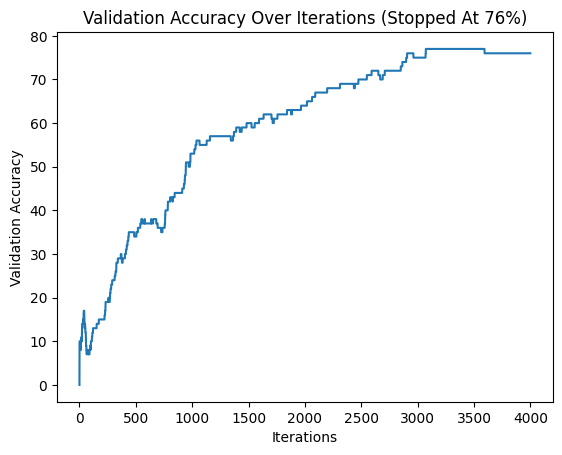

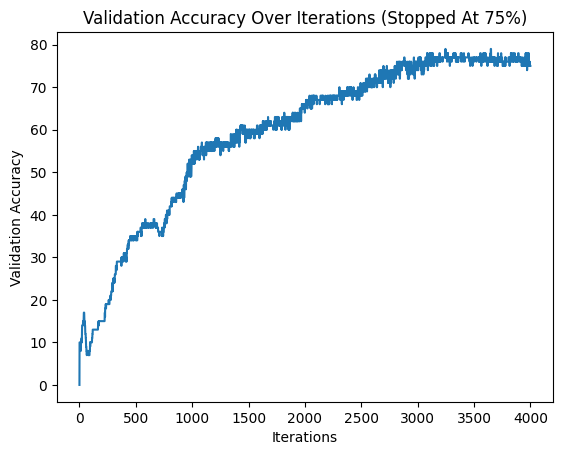

In [ ]:
# create a neural network
nn = NeuralNetwork(dim_x=x_matrix.shape[1], dim_y=y_matrix.shape[1], layers=2, neurons=16, activation=torch.sigmoid)

# train the neural network and show plot of validation accuracy over iterations
nn, val_acc, seconds, iterations = nn.train(x_matrix, y_matrix, val_matrix, val_labels, batch_size=None, show=True)

# create a neural network
nn = NeuralNetwork(dim_x=x_matrix.shape[1], dim_y=y_matrix.shape[1], layers=2, neurons=16, activation=torch.sigmoid)

# train the neural network and show plot of validation accuracy over iterations
nn, val_acc, seconds, iterations = nn.train(x_matrix, y_matrix, val_matrix, val_labels, batch_size=100, show=True)

The two plots above are for 2 hidden layers, 16 neurons per layer, sigmoid activation function neural networks. The first plot is trained with all of the training data, while the second plot is trained on mini-batches of 100. The lines on the plots are very similar, with the only difference being noise in the mini-batch plot. Using mini-batches to train the neural network produces an unstable line because the gradients found during mini-batch stochastic gradient descent may not be the fastest way to minimize training loss and may even increase it as well. As a result, batch gradient descent produces a more stable line, as it takes the fastest way to minimize training loss. The plots for the other neural network models also show this.

The stopping condition used was if the current validation accuracy average of the past 500 iterations is less than or equal to the previous validation accuracy average. In other words, if the current average is not greater, then the validation accuracy seems to not be increasing anymore. As seen in the plots and shown in the table below, both plots stopped after 4000 iterations.

| Hidden Layers | Neurons Per Layer | Activation Function | Training Method | Validation Accuracy | Test Accuracy | Time Taken (s) | Iterations/Updates |
| :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: |
| 2 | 16 | sigmoid | batch | 76 | 73 | 6.9969 | 4000 |
| 2 | 16 | sigmoid | mini-batch | 75 | 72 | 5.5708 | 4000 |
| 2 | 16 | atan | batch | 82 | 80 | 4.4061 | 2000 |
| 2 | 16 | atan | mini-batch | 83 | 80 | 2.9345 | 2000 |
| 2 | 16 | relu | batch | 74 | 77 | 4.3299 | 3000 |
| 2 | 16 | relu | mini-batch | 80 | 83 | 8.5384 | 5500 |
| 2 | 32 | sigmoid | batch | 79 | 78 | 5.6302 | 2500 |
| 2 | 32 | sigmoid | mini-batch | 78 | 77 | 4.7374 | 2500 |
| 2 | 32 | atan | batch | 85 | 80 | 5.2237 | 2000 |
| 2 | 32 | atan | mini-batch | 85 | 82 | 3.5074 | 2000 |
| 2 | 32 | relu | batch | 84 | 77 | 7.5921 | 3500 |
| 2 | 32 | relu | mini-batch | 88 | 79 | 6.7077 | 4000 |
| 2 | 64 | sigmoid | batch | 84 | 81 | 12.0955 | 2500 |
| 2 | 64 | sigmoid | mini-batch | 89 | 84 | 22.4058 | 11500 |
| 2 | 64 | atan | batch | 80 | 78 | 10.7922 | 2000 |
| 2 | 64 | atan | mini-batch | 84 | 78 | 8.2723 | 3500 |
| 2 | 64 | relu | batch | 79 | 79 | 5.9578 | 1500 |
| 2 | 64 | relu | mini-batch | 81 | 82 | 15.617 | 8000 |
| 3 | 16 | sigmoid | batch | 84 | 79 | 15.2575 | 7500 |
| 3 | 16 | sigmoid | mini-batch | 83 | 82 | 12.3446 | 7500 |
| 3 | 16 | atan | batch | 83 | 82 | 4.1447 | 2000 |
| 3 | 16 | atan | mini-batch | 83 | 83 | 4.9533 | 2500 |
| 3 | 16 | relu | batch | 81 | 74 | 5.0668 | 3000 |
| 3 | 16 | relu | mini-batch | 77 | 75 | 3.7853 | 2500 |
| 3 | 32 | sigmoid | batch | 74 | 69 | 6.1048 | 2000 |
| 3 | 32 | sigmoid | mini-batch | 85 | 80 | 17.1174 | 9500 |
| 3 | 32 | atan | batch | 86 | 82 | 13.3443 | 4000 |
| 3 | 32 | atan | mini-batch | 86 | 81 | 6.2615 | 3000 |
| 3 | 32 | relu | batch | 72 | 64 | 5.8002 | 2500 |
| 3 | 32 | relu | mini-batch | 75 | 66 | 5.723 | 3000 |
| 3 | 64 | sigmoid | batch | 83 | 81 | 19.8774 | 3500 |
| 3 | 64 | sigmoid | mini-batch | 88 | 84 | 20.2089 | 8500 |
| 3 | 64 | atan | batch | 82 | 82 | 24.0986 | 3500 |
| 3 | 64 | atan | mini-batch | 79 | 80 | 4.7782 | 2000 |
| 3 | 64 | relu | batch | 75 | 63 | 16.128 | 3000 |
| 3 | 64 | relu | mini-batch | 70 | 66 | 3.9648 | 1500 |
| 4 | 16 | sigmoid | batch | 77 | 75 | 15.3012 | 7000 |
| 4 | 16 | sigmoid | mini-batch | 87 | 84 | 24.3629 | 13500 |
| 4 | 16 | atan | batch | 85 | 82 | 6.7435 | 2500 |
| 4 | 16 | atan | mini-batch | 85 | 81 | 7.1333 | 4000 |
| 4 | 16 | relu | batch | 78 | 74 | 8.2609 | 4000 |
| 4 | 16 | relu | mini-batch | 80 | 75 | 4.9153 | 3000 |
| 4 | 32 | sigmoid | batch | 82 | 81 | 15.6248 | 4500 |
| 4 | 32 | sigmoid | mini-batch | 84 | 83 | 9.7144 | 5000 |
| 4 | 32 | atan | batch | 87 | 78 | 16.4298 | 4000 |
| 4 | 32 | atan | mini-batch | 85 | 81 | 5.0789 | 2500 |
| 4 | 32 | relu | batch | 77 | 66 | 10.3867 | 3500 |
| 4 | 32 | relu | mini-batch | 84 | 69 | 5.3969 | 3000 |
| 4 | 64 | sigmoid | batch | 84 | 78 | 18.3781 | 2500 |
| 4 | 64 | sigmoid | mini-batch | 86 | 83 | 22.8963 | 8500 |
| 4 | 64 | atan | batch | 78 | 72 | 50.9847 | 6000 |
| 4 | 64 | atan | mini-batch | 72 | 78 | 4.1977 | 1500 |
| 4 | 64 | relu | batch | 61 | 61 | 12.6639 | 2000 |
| 4 | 64 | relu | mini-batch | 62 | 59 | 12.7149 | 5000 |

The highest test accuracy was 84% using the following neural networks:
* 2 hidden layers, 64 neurons per layer, sigmoid activation function,	mini-batch training (89% validation accuracy, 84% test accuracy, 22.4058 seconds, 11500 iterations)
* 3 hidden layers, 64 neurons per layer, sigmoid activation function, mini-batch training (88% validation accuracy, 84% test accuracy, 20.2089 seconds, 8500 iterations)
* 4	hidden layers, 16 neurons per layer, sigmoid activation function, mini-batch training (87% validation accuracy, 84% test accuracy, 24.3629 seconds, 13500 iterations)

It is interesting to see that all of the above neural networks used a sigmoid activation function and were trained on mini-batches. There is also one neural network with each number of hidden layers (2, 3, 4). In addition, all of them have high validation accuracies, which is to be expected.

|Hidden Layers|Validation Accuracy|Test Accuracy|Time Taken (s)|Iterations/Updates|
|:-:|:-:|:-:|:-:|:-:|
|2|81.4444|78.8889|7.8509|3666.6667|
|3|80.3333|76.2778|10.4977|3944.4444|
|4|79.6667|75.5556|13.9547|4555.5556|

|Neurons Per Layer|Validation Accuracy|Test Accuracy|Time Taken (s)|Iterations/Updates|
|:-:|:-:|:-:|:-:|:-:|
|16|80.7222|78.3889|8.0581|4416.6667|
|32|82.0|76.2778|8.3545|3500.0|
|64|78.7222|76.0556|15.8907|4250.0|

|Activation Function|Validation Accuracy|Test Accuracy|Time Taken (s)|Iterations/Updates|
|:-:|:-:|:-:|:-:|:-:|
|sigmoid|82.1111|79.1111|14.1458|5916.6667|
|atan|82.7778|80.0|10.1825|2833.3333|
|relu|76.5556|71.6111|7.975|3416.6667|

|Training Method|Validation Accuracy|Test Accuracy|Time Taken (s)|Iterations/Updates|
|:-:|:-:|:-:|:-:|:-:|
|batch|79.7037|75.7778|12.1341|3333.3333|
|mini-batch|81.2593|78.037|9.4014|4777.7778|

On average, the 2 hidden layers neural networks performed the best, as it had better validation and test accuracies with the least time taken and the least number of iterations. The time taken seems to be less when there are less hidden layers, which makes sense as there are less computations to perform. The number of iterations are also less with less hidden layers. The validation and test accuracies seem to go down with more hidden layers.

On average, 16 neurons per layer neural networks had the highest test accuracy but took the least amount of time and the most number of iterations. 64 neurons per layer neural networks took almost double the amount of time that 16 and 32 neurons per layer neural networks took.

On average, atan activation function neural networks had the highest validation and test accuracies, despite having the least number of iterations. Sigmoid activation function neural networks took much more iterations and time to finish than other activation function neural networks. Relu activation function neural networks performed much worse than the other activation function neural networks in both validation and test accuracy but took the least amount of time to finish.

On average, mini-batch trained neural networks performed the best in all aspects other than iterations. Mini-batch training took less time than batch training, while taking more iterations to finish. This is expected when comparing batch and mini-batch training. Mini-batch training also had higher validation and test accuracies.